<a href="https://colab.research.google.com/github/chang-heekim/Implementation_Deep_Learning_Paper/blob/main/VAE_for__MNIST_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Necessary Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import mnist

# Set up hyper parameters

In [ ]:
input_shape = 784
latent_dim = 2
intermediate_dim = 512
original_dim = input_shape

# Load Mnist Dataset

In [ ]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()
print(f'Train Shape: {train_x.shape}, Test Shape: {test_x.shape}')

11501568/11490434 [==============================] - 0s 0us/step
Train Shape: (60000, 28, 28), Test Shape: (10000, 28, 28)


In [ ]:
train_x = np.reshape(train_x, (train_x.shape[0], -1)) / 255.
test_x = np.reshape(test_x, (test_x.shape[0], -1)) / 255.

print(f'Train Shape: {train_x.shape}, Test Shape: {test_x.shape}')

Train Shape: (60000, 784), Test Shape: (10000, 784)


# Define VAE

In [ ]:
def encoder():
    inputs = Input(shape=(784, ))

    hidden_layer = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(2)(hidden_layer)
    log_var = Dense(2)(hidden_layer)

    def sampling(args):
        z_mean, log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.compat.v2.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * log_var) * epsilon

    z_sampling = tf.keras.layers.Lambda(sampling, (2,))([z_mean, log_var])

    return tf.keras.Model(inputs, [z_mean, log_var, z_sampling], name='Encoder')

encoder = encoder()
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          401920      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2)            1026        ['dense[0][0]']                  
                                                                                            

In [ ]:
def decoder():
    inputs = Input((2,))
    hidden_layer = Dense(intermediate_dim, activation='relu')(inputs)

    outputs = Dense(784, activation='sigmoid')(hidden_layer)
    return tf.keras.Model(inputs, outputs, name='Decoder')

decoder = decoder()
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 512)               1536      
                                                                 
 dense_4 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def vae():
    inputs = Input((784,))
    z_mean, log_var, z_sampling = encoder(inputs)
    outputs = decoder(z_sampling)
    return tf.keras.Model(inputs, outputs, name='VAE')

# Setting Model & Optimizer & Loss

In [ ]:
epochs = 50
batch_size = 64
lr = 1e-4
intermediate_dim = 512

def vae_loss(targets, preds):
    z_mean, log_var, z_sampling = encoder(targets)
    outputs = decoder(z_sampling)
    loss = tf.keras.losses.binary_crossentropy(targets, outputs)
    loss *= original_dim
    # loss = tf.keras.losses.mse(targets, preds)
    kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.exp(log_var) - log_var - 1, 1)
    return tf.reduce_mean(loss + kl_loss)

model = vae()
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=vae_loss
)

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 Encoder (Functional)        [(None, 2),               403972    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 Decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
hist = model.fit(train_x, train_x, epochs=epochs, batch_size=batch_size)

Epoch 1/50
938/938 [==============================] - 10s 6ms/step - loss: 243.2229
Epoch 2/50
938/938 [==============================] - 4s 5ms/step - loss: 186.8592
Epoch 3/50
938/938 [==============================] - 4s 4ms/step - loss: 179.1104
Epoch 4/50
938/938 [==============================] - 4s 4ms/step - loss: 174.1735
Epoch 5/50
938/938 [==============================] - 4s 4ms/step - loss: 171.5626
Epoch 6/50
938/938 [==============================] - 4s 4ms/step - loss: 170.0027
Epoch 7/50
938/938 [==============================] - 4s 4ms/step - loss: 168.8094
Epoch 8/50
938/938 [==============================] - 4s 4ms/step - loss: 167.8230
Epoch 9/50
938/938 [==============================] - 4s 4ms/step - loss: 166.9863
Epoch 10/50
938/938 [==============================] - 4s 4ms/step - loss: 166.1968
Epoch 11/50
938/938 [==============================] - 4s 4ms/step - loss: 165.4783
Epoch 12/50
938/938 [==============================] - 4s 4ms/step - loss: 164.8172


# Visualization input images & reconstruction images

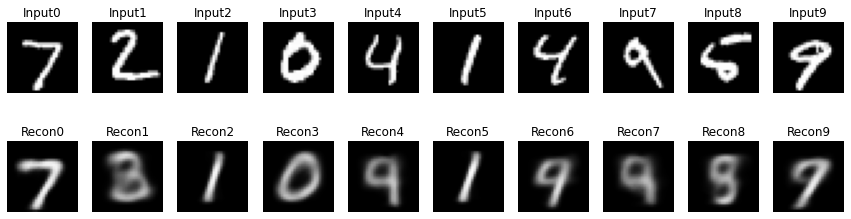

In [ ]:
recon_x = model.predict(test_x)

n = 10  
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_x[i].reshape(28,28), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x[i].reshape(28, 28),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    plt.axis('off')

plt.show()